# Analysis of the outflow of clients from the bank

#  Materials

**Presentation:** https://drive.google.com/file/d/1mu1Zv38WjTsFO6rBSu9kWQHmMsmdSpDx/view?usp=sharing

# Description of the project

It is necessary to perform an analysis of the churn of clients from the bank. The analysis will show which clients are leaving the bank, and will also help to make up segments of clients who tend to leave the bank.

# The purpose and tasks of the project

**The purpose of the project:** create a portrait of clients who are prone to churn from the bank  

**Tasks:**  
- Perform data preprocessing  
- Perform an exploratory data analysis  
- Test statistical hypotheses  
- Identify client segments prone to churn  
- Prepare a presentation based on the results of the analysis

# Description of the data

`/datasets/bank_scrooge.csv`   
The dataset contains data about the clients of Metanprom Bank. The bank is located in Yaroslavl and the regional cities of Rostov Veliky and Rybinsk.  

**Columns:**  
- `USERID` - user ID  
- `score` - credit scoring points  
- `city` - city  
- `gender` - gender  
- `age` - age  
- `equity` - the number of ownership points  
- `balance` - account balance  
- `products` - the number of products that the customer uses  
- `credit_card` - is there a credit card  
- `last_activity` - active client  
- `EST_SALARY` - estimated income of the client  
- `churn` is a sign of outflow

## Downloading and reviewing data

In [1]:
# download the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import math

In [2]:
# download the dataset and look at the data
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
display(data.head(10))

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


In [3]:
# look at the general information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Based on the data viewed and the information received, it is clear that it is necessary to perform data preprocessing.  
The names of some columns do not correspond to the code style, the `age` and `balance` columns have missing values, the `age`, `credit_card`, `last_activity` and `churn` columns have an incorrect data type.

## Data preprocessing

### Convert the column names to the correct style

In [4]:
# convert the names of all columns to lowercase
data.columns = data.columns.str.lower()

# convert the column name userid to snake_case
data = data.rename(columns = {'userid':'user_id'})

data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


### Handle missing data

Check the proportion of missing values in the `age` column

In [5]:
# calculate the proportion of missing values in the `age` column relative to the total count
percent_age = len(data[data['age'].isna()])/len(data)*100
print(f'Percentage of missing values in the `age` column relative to the total count {percent_age} %')

Percentage of missing values in the `age` column relative to the total count 0.26 %


In [6]:
# create a new column indicating missing values in the `age` column: `1` for missing, `0` for not missing.
data['age_nan'] = data['age'].isna().astype(int)

# create a pivot table based on the `age_nan` column, calculating measures of central tendency for specific features.
# x.value_count counts how many times each unique value occurs in a column
# .index[0] selects the first index that corresponds to the most frequently occurring value

data.groupby('age_nan').agg({
    'score':['median'],
    'city':lambda x: x.value_counts().index[0], # mode
    'gender':lambda x: x.value_counts().index[0], # mode
    'credit_card':['sum'],
    'est_salary':['median'],
    'churn':['sum']
})

,score,city,gender,credit_card,est_salary,churn
,median,<lambda>,<lambda>,sum,median,sum
age_nan,,,,,,
0,853.0,Ярославль,М,6784,119626.795,1819
1,888.5,Ярославль,М,20,142598.860,1


There are no clear signs that can tell why the data in the `age` column is missing. Also, the percentage of omissions in this column is only 0.26%.  
In this case, we can delete rows with missing values in the `age` column - this will not affect the data analysis.

In [7]:
# delete the rows with gaps in the age column
data = data.dropna(subset=['age'])

Look at the percentage of missing values in the `balance` column

In [8]:
# calculate the proportion of missing values in the `balance` column relative to the total count
percent_balance = len(data[data['balance'].isna()])/len(data)*100
print(f'Percentage of missing values in the `balance` column relative to the total count {percent_balance:.2f} %')

Percentage of missing values in the `balance` column relative to the total count 22.85 %


In this case, we are not be able to delete rows with missing values in the `balance` column, because the percentage of missig values is quite large - more than 20 %

In [9]:
# create a new column indicating missing values in the `balance` column: `1` for missing, `0` for not missing.
data['balance_nan'] = data['balance'].isna().astype(int)

# create a pivot table based on the `balance_nan` column, calculating measures of central tendency for specific features.
# x.value_count counts how many times each unique value occurs in a column
# .index[0] selects the first index that corresponds to the most frequently occurring value

data.groupby('balance_nan').agg({
    'score':['median'],
    'city':lambda x: x.value_counts().index[0], # мода
    'gender':lambda x: x.value_counts().index[0], # мода
    'credit_card':['sum'],
    'est_salary':['median'],
    'churn':['sum']
})

,score,city,gender,credit_card,est_salary,churn
,median,<lambda>,<lambda>,sum,median,sum
balance_nan,,,,,,
0,840.0,Ярославль,Ж,4926,106250.18,1806
1,903.0,Ярославль,М,1858,174347.87,13


Based on the differences in estimated income, it can be assumed that the missing values in the `balance` may not be accidental.  
But it is impossible to draw an unambiguous conclusion, so in this case it makes sense to leave the gaps empty, since they may reflect the behavior of clients with higher income.

Now we can delete the columns `age_nan` and `balance_non`

In [10]:
data = data.drop(columns = ['age_nan', 'balance_nan'], axis = 1)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


### Data encoding

Depending on which approach to working with correlation will be chosen, we may need to encode categorical disordered variables. These are the columns `city` and `gender`.

In [11]:
# make copies of the city and gender columns
data['city_2'] = data['city']
data['gender_2'] = data['gender']

# encode the data in the city_2 and gender_2 columns
data = pd.get_dummies(data, columns = ['city_2', 'gender_2'])

# rename the columns
data = data.rename(columns = ({
                   'city_2_Ростов':'Rostov', 
                   'city_2_Рыбинск':'Rybinsk',
                   'city_2_Ярославль':'Yaroslavl',
                   'gender_2_Ж':'female',
                   'gender_2_М':'male'}))
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,female,male
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,False,True,False,True,False
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,False,True,False,True,False
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,False,True,False,True,False
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,False,False,True,True,False
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,False,False,True,False,True


Now we have columns with city names and gender that will be useful for further research.

### Checking data for duplicates

Check the dataset for obvious duplicates

In [12]:
# calculate the sum of the obvious duplicates
data.duplicated().sum()

0

There are no obvious duplicates.  
Check the dataset for implicit duplicates of the `user_id` column. There are shouldn't be duplicates, because 'user_id` is a unique client number.

In [13]:
# count the number of duplicates
data['user_id'].duplicated().sum()

50

There are 50 duplicates in the `user_id` column.  
Let's see what the duplicate strings look like.

In [14]:
# create a table with duplicates by the user_id column
duplicates_user_id = data[data.duplicated(subset='user_id', keep = False)] #keep False keeps duplicates
duplicates_user_id

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,female,male
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1,False,False,True,False,True
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1,False,True,False,False,True
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1,False,True,False,True,False
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1,False,True,False,False,True
690,152479,768.0,Рыбинск,Ж,42.0,0,126787.79,4,1,1,143233.23,1,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9659,195884,767.0,Рыбинск,Ж,45.0,1,335652.56,3,1,1,100197.67,0,False,True,False,True,False
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,False,True,False,True,False
9785,168998,895.0,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0,False,True,False,False,True
9880,217412,886.0,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0,False,False,True,True,False


In [15]:
# sort the table by user_id to see how the data differs for the rest of the columns
duplicates_user_id.sort_values(by='user_id').head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,female,male
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,False,True,False,True,False
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,False,False,True,True,False
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,False,True,False,True,False
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,False,False,True,True,False
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,False,True,False,True,False
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,False,False,True,False,True
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1,False,False,True,True,False
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0,False,True,False,False,True
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,False,True,False,True,False
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1,False,False,True,True,False


The data for the remaining columns is significantly different. A client with the same user_id may have different cities, different ages, and even different genders.  
It can be assumed that in some cases the client may move to another city, accordingly, the data about the city will change, or maybe just a unique number was assigned incorrectly.  
In any case, there are not many duplicates, and if we just leave them, it will not spoil the overall picture of the analysis

### Change the data types in the columns

In [16]:
# change the data types
data['age'] = data['age'].astype(int)
data['credit_card'] = data['credit_card'].astype('bool')
data['last_activity'] = data['last_activity'].astype('bool')
data['churn'] = data['churn'].astype('bool')

### Clients with the number of products equal to 0

Check if there are clients in the dataset who have the number of products equal to 0

In [17]:
# find customers where the number of products is 0
zero_products = data.query('products == 0') 
zero_products

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,female,male
8957,147837,962.0,Рыбинск,Ж,79,3,NaN,0,False,False,25063.96,True,False,True,False,True,False


Such client cannot actually be a client of the bank, because he does not own any product.  
Delete this line from the dataset

In [18]:
# delete the row with the number of products equal to 0
data = data.query('products != 0')

**After preprocessing, look at the general information about the dataset**

In [19]:
# look at the general information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9973 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9973 non-null   int64  
 1   score          9973 non-null   float64
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   int64  
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   bool   
 9   last_activity  9973 non-null   bool   
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   bool   
 12  Rostov         9973 non-null   bool   
 13  Rybinsk        9973 non-null   bool   
 14  Yaroslavl      9973 non-null   bool   
 15  female         9973 non-null   bool   
 16  male           9973 non-null   bool   
dtypes: bool(8), float64(3), int64(4), object(2)
memory usage:

**Conclusion**  
As part of the data preprocessing, the column names were renamed according to the code style, an analysis of missing values was made, an analysis of duplicates was carried out, and categorical columns were encoded for further correlation analysis.

## Exploratory data analysis

### Comparison of portraits of typical clients

Create a table with central trends for all the features and add the relative difference for continuous values.

In [20]:
# create a table with the calculation of the central trends
grouped_data = data.groupby('churn').agg({
    'score': ['mean', 'median'],
    'age': ['mean', 'median'],
    'balance': ['mean', 'median'],
    'equity': ['median'],
    'est_salary': ['mean', 'median'],
    'products': ['median'],
    'credit_card': ['median'],
    'last_activity': ['median'],
    'city': lambda x: x.value_counts().index[0],  # mode
    'gender': lambda x: x.value_counts().index[0]  # mode
}).reset_index()

grouped_data

churn       score               age              balance            equity  \
                mean median       mean median          mean     median median   
0  False  845.396199  848.0  43.020846   40.0  7.330316e+05  475410.09    3.0   
1   True  863.361936  866.0  41.429593   39.0  1.134458e+06  783908.90    4.0   

      est_salary            products credit_card last_activity       city  \
            mean     median   median      median        median   <lambda>   
0  147674.637881  118227.60      2.0         1.0           0.0  Ярославль   
1  148357.483157  125408.88      2.0         1.0           1.0  Ярославль   

    gender  
  <lambda>  
0        Ж  
1        М

In [21]:
# transpose the table
new_grouped_data = grouped_data.T

# rename the columns
new_grouped_data.columns = ['Not churn', 'Churn']
new_grouped_data

Not churn           Churn
churn                           False            True
score         mean         845.396199      863.361936
              median            848.0           866.0
age           mean          43.020846       41.429593
              median             40.0            39.0
balance       mean      733031.630149  1134458.209291
              median        475410.09        783908.9
equity        median              3.0             4.0
est_salary    mean      147674.637881   148357.483157
              median         118227.6       125408.88
products      median              2.0             2.0
credit_card   median              1.0             1.0
last_activity median              0.0             1.0
city          <lambda>      Ярославль       Ярославль
gender        <lambda>              Ж               М

In [22]:
# calculate the relative difference for continuous quantities
continuous_features = ['score', 'age', 'balance', 'est_salary']

for feature in continuous_features:
    mean_churn_true = grouped_data[feature]['mean'][grouped_data['churn'] == 1].values[0]
    mean_churn_false = grouped_data[feature]['mean'][grouped_data['churn'] == 0].values[0]
    relative_difference = (mean_churn_true - mean_churn_false) / mean_churn_false * 100
    print(f"Relative difference for {feature}: {relative_difference:.2f}%")


Relative difference for score: 2.13%
Relative difference for age: -3.70%
Relative difference for balance: 54.76%
Relative difference for est_salary: 0.46%


There is practically no relative difference between continuous values. The exception is the balance. The average account balance of not churn clients is 12% more than that of churn ones. Otherwise, there is practically no difference.

**Also, look at the general portrait of clients in the context of different parameters**  

Look at the client shares in the context of the parameters `city`, `gender`, `credit_card`, `last_activity` and `churn'. Let's build pie charts for these parameters.

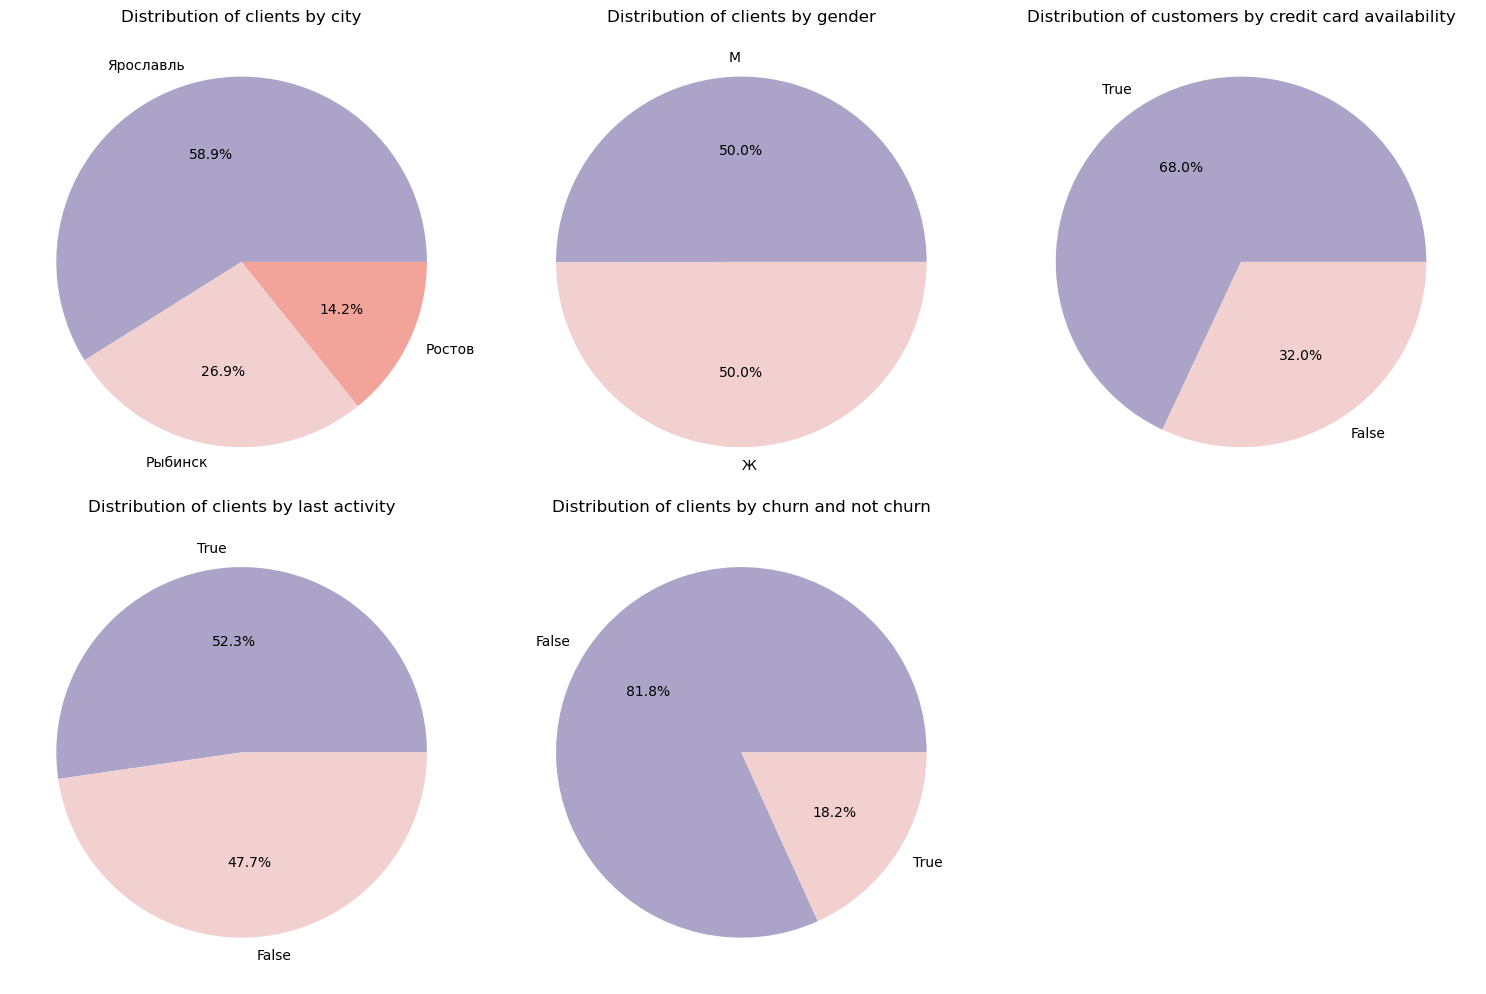

In [23]:
# setting up the number of subgraphs (1 row and 5 columns)
fig, axes = plt.subplots(2, 3, figsize=(15,10))

# build a pie chart for the city
data['city'].value_counts().plot.pie(ax=axes[0, 0], autopct='%1.1f%%', colors=['#aca3c8', '#f2d0d0', '#f2a39a'])
axes[0, 0].set_title('Distribution of clients by city')
axes[0, 0].set_ylabel('')

# build a pie chart for gender
data['gender'].value_counts().plot.pie(ax=axes[0, 1], autopct='%1.1f%%', colors=['#aca3c8', '#f2d0d0'])
axes[0, 1].set_title('Distribution of clients by gender')
axes[0, 1].set_ylabel('')

# build a pie chart for credit_card
data['credit_card'].value_counts().plot.pie(ax=axes[0, 2], autopct='%1.1f%%', colors=['#aca3c8', '#f2d0d0'])
axes[0, 2].set_title('Distribution of customers by credit card availability')
axes[0, 2].set_ylabel('')

# build a pie chart for last_activity
data['last_activity'].value_counts().plot.pie(ax=axes[1, 0], autopct='%1.1f%%', colors=['#aca3c8', '#f2d0d0'])
axes[1, 0].set_title('Distribution of clients by last activity')
axes[1, 0].set_ylabel('')

# build a pie chart for churn
data['churn'].value_counts().plot.pie(ax=axes[1, 1], autopct='%1.1f%%', colors=['#aca3c8', '#f2d0d0'])
axes[1, 1].set_title('Distribution of clients by churn and not churn')
axes[1, 1].set_ylabel('')

# disable the axes in the last cell
axes[1, 2].axis('off')

# show all the diagrams
plt.tight_layout()
plt.show()

Look at the distribution of clients in the context of the continuous parameters `score`, `age`, `balance` and `est_salary'. For these parameters, we will construct histograms of the distribution.

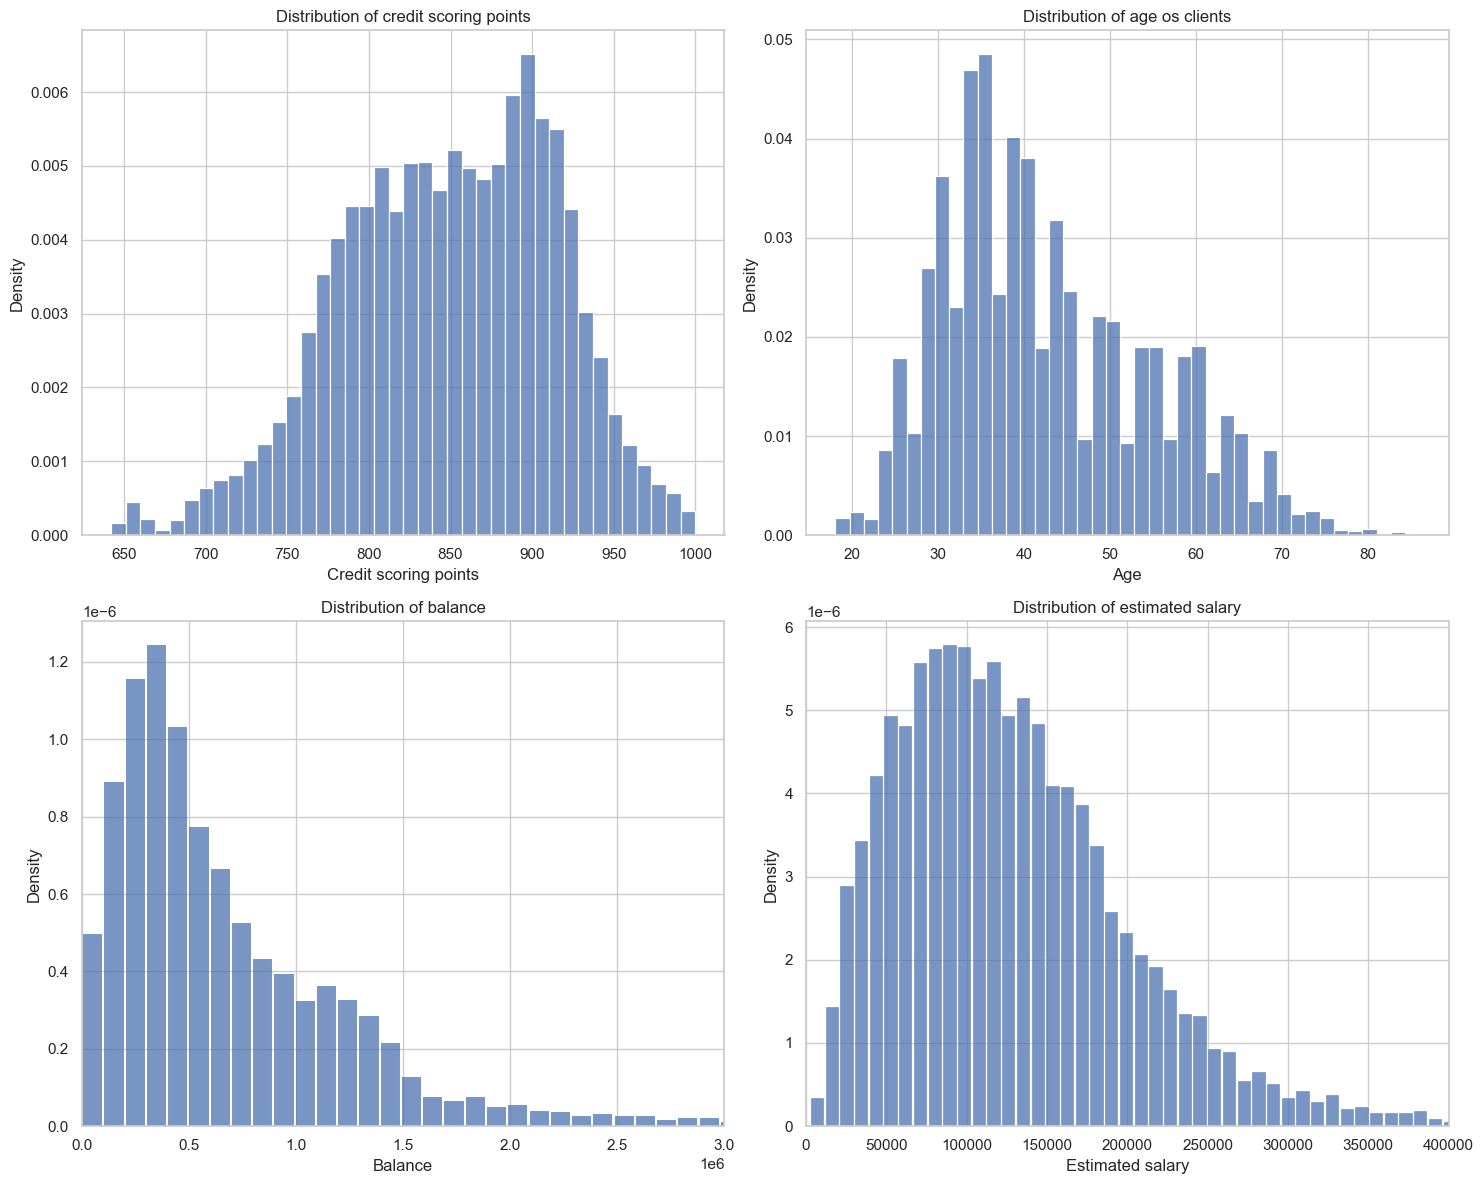

In [24]:
# set the style for the graphs
sns.set(style="whitegrid")

# set the size of the graphs
plt.figure(figsize=(15, 12))

# build histograms for each feature
# score
plt.subplot(2, 2, 1)
sns.histplot(data=data, x="score", stat="density")
plt.title("Distribution of credit scoring points")
plt.xlabel("Credit scoring points")

# age
plt.subplot(2, 2, 2)
sns.histplot(data=data, x="age", stat="density")
plt.title("Distribution of age os clients")
plt.xlabel("Age")

# balance
plt.subplot(2, 2, 3)
sns.histplot(data=data, x="balance", stat="density", bins=1200, shrink=0.9)
plt.xlim(0, 3000000)
plt.title("Distribution of balance")
plt.xlabel("Balance")

# estimated salary
plt.subplot(2, 2, 4)
sns.histplot(data=data, x="est_salary", stat="density", shrink=0.9)
plt.xlim(0, 400000)
plt.title("Distribution of estimated salary")
plt.xlabel("Estimated salary")

# show all graphs
plt.tight_layout()
plt.show()

Also, look at the distribution of clients in the context of the parameters `equity` and `products'. For these parameters, we will construct columnar histograms

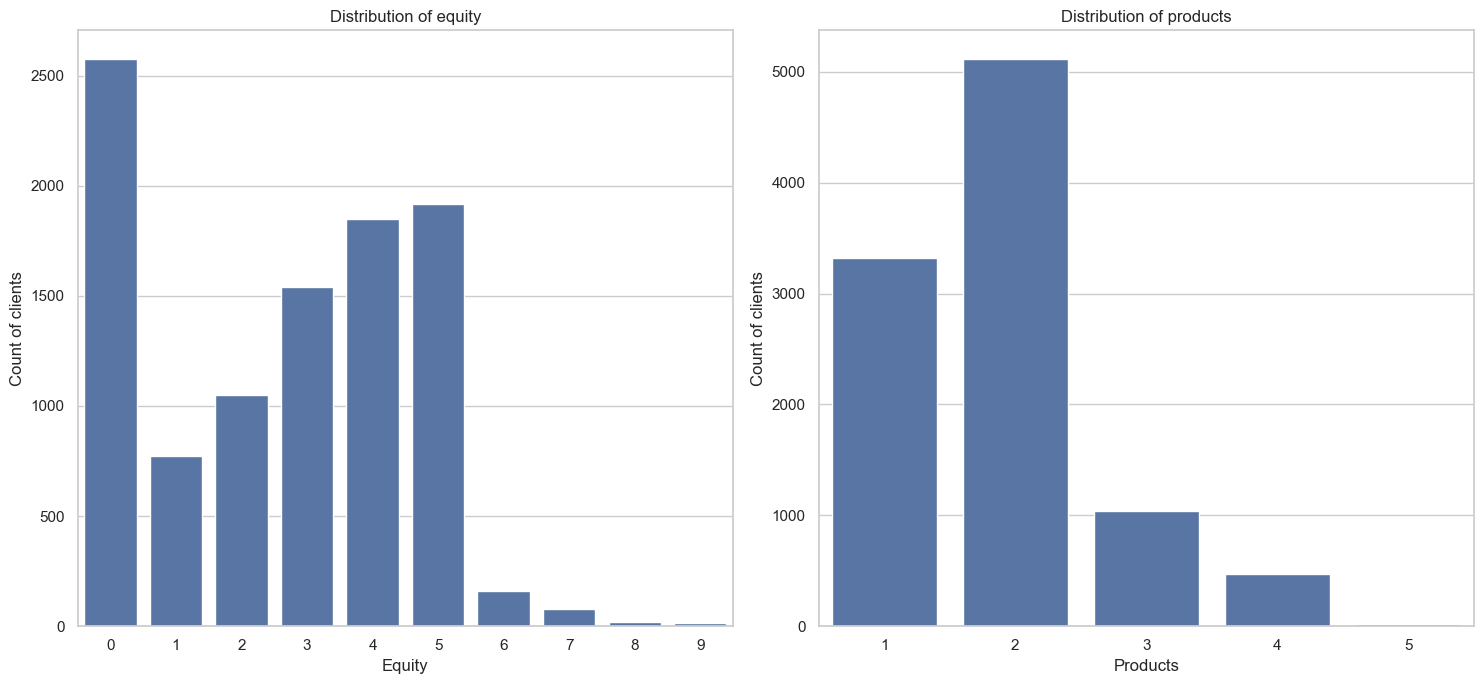

In [25]:
# set the size of the graphs
plt.figure(figsize=(15, 7))

# build histograms for each feature
# equity
plt.subplot(1, 2, 1)
sns.countplot(data=data, x="equity")
plt.title("Distribution of equity")
plt.xlabel("Equity")
plt.ylabel("Count of clients")

# products
plt.subplot(1, 2, 2)
sns.countplot(data=data, x="products")
plt.title("Distribution of products")
plt.xlabel("Products")
plt.ylabel("Count of clients")

# show all graphs
plt.tight_layout()
plt.show()

**Conclusion**  
Based on the graphs above, we can make the following conclusions:  
- about 59% of the bank's clients are served in Yaroslavl, about 27% in Rybinsk and 14% in Rostov  
- there are 50/50 men and women in the bank  
- 68% of the bank's clients have a credit card
- in the last 3 months, about 52% of clients have been active 
- approximately 82% of clients are not inclined to churn  
- most clients have a credit rating from 750 to 950  
- most of the clients are between the ages of 30 and 40  
- the most common balance on the client's account is from 200 thousand rubles to 700 thousand rubles.  
- the most common estimated income of clients is from 40 thousand rubles to 180 thousand rubles.  
- most of the bank's clients are without property  
- most often, users have 2 products in the bank

### Distribution of various parameters in the context of churn

**Study the distribution of categorical characteristics in the context of churn**

Consider the proportion of exact clients by city

In [26]:
# make a pivot table with the shares from the churn clients in each city
city_churn = data.pivot_table(index='city', values='churn', aggfunc=['sum', 'count'])
city_churn = pd.DataFrame(city_churn.reset_index()) 
city_churn.columns = ['city', 'sum_churn', 'sum_total'] # assign the names of the columns in the table
city_churn['churn_share'] = city_churn['sum_churn']/city_churn['sum_total']*100 # creating a new column with a share from the churn customers
city_churn['churn_share'] = city_churn['churn_share'].round(2) # rounding the percentage to 2 decimal places
city_churn

,city,sum_churn,sum_total,churn_share
0,Ростов,265,1416,18.71
1,Рыбинск,436,2682,16.26
2,Ярославль,1117,5875,19.01


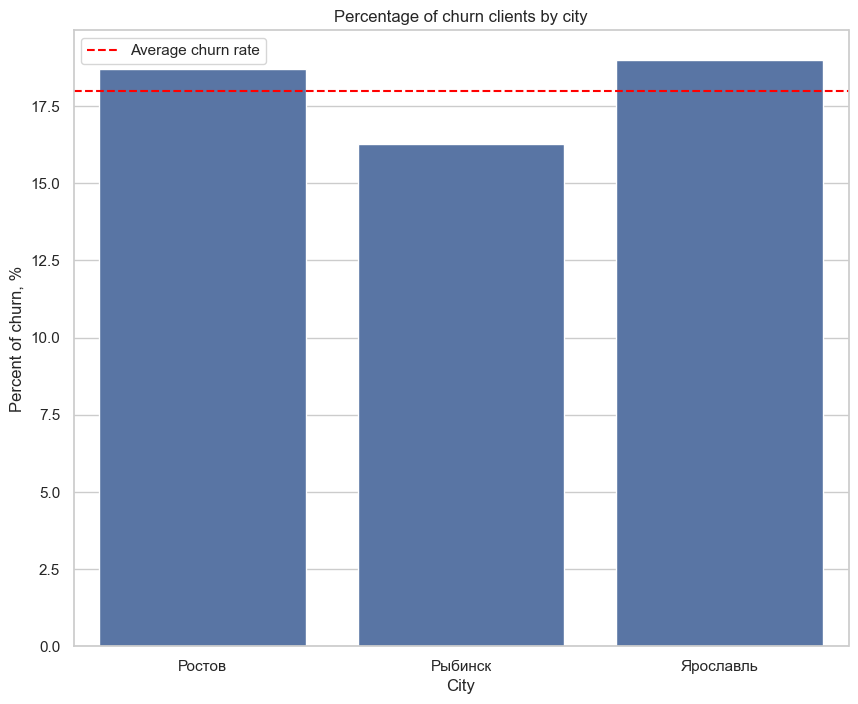

In [27]:
# calculate the average churn share for the bank
mean_churn_share = city_churn['churn_share'].mean()

# build a bar chart with shares from churn customers by city
plt.figure(figsize=(10,8))
sns.barplot(x='city', y='churn_share', data=city_churn)
# add the line of the average outflow fraction
plt.axhline(mean_churn_share, color='red', linestyle='--', label='Average churn rate')
plt.title('Percentage of churn clients by city')
plt.xlabel('City')
plt.ylabel('Percent of churn, %')
plt.legend()
plt.show()

In all cities, the share of churn clients is less than 20%. In Rybinsk is the smallest share - 16.26%

Consider the proportion of churn clients by gender

In [28]:
# make a pivot table with shares from churn clients by gender
gender_churn = data.pivot_table(index='gender', values='churn', aggfunc=['sum', 'count'])
gender_churn = pd.DataFrame(gender_churn.reset_index()) 
gender_churn.columns = ['gender', 'sum_churn', 'sum_total'] # assign the names of the columns in the table
gender_churn['churn_share'] = gender_churn['sum_churn']/gender_churn['sum_total']*100 # creating a new column with a share from the churn customers
gender_churn['churn_share'] = gender_churn['churn_share'].round(2) # rounding the percentage to 2 decimal places
gender_churn

,gender,sum_churn,sum_total,churn_share
0,Ж,635,4982,12.75
1,М,1183,4991,23.70


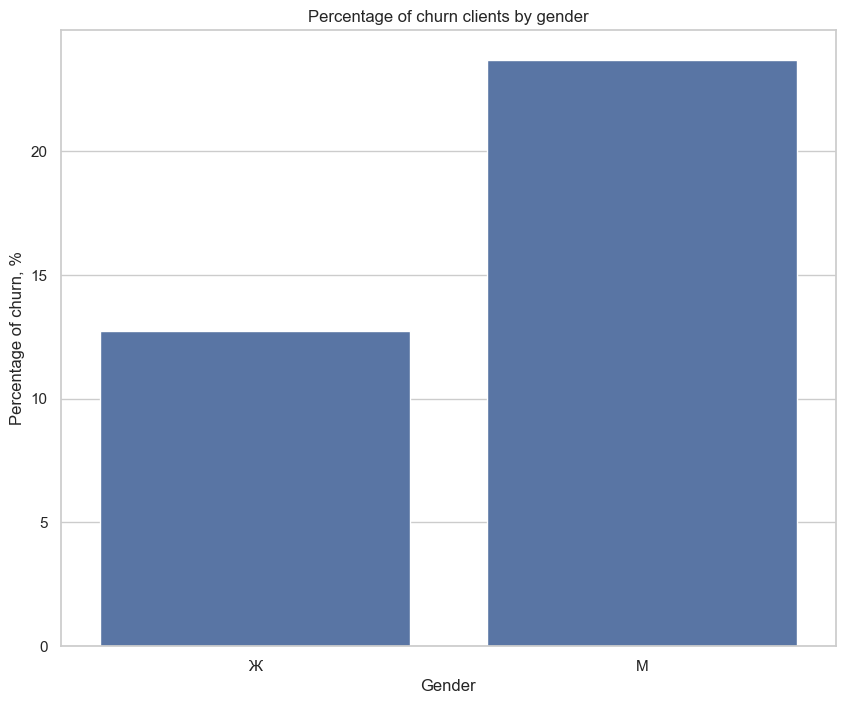

In [29]:
# build a bar chart with shares from churn clients by gender
plt.figure(figsize=(10,8))
sns.barplot(x='gender', y='churn_share', data=gender_churn)
plt.title('Percentage of churn clients by gender')
plt.xlabel('Gender')
plt.ylabel('Percentage of churn, %')
plt.show()

According to the chart, it can be seen that the proportion of churn men is more than the proportion of churn women by 11%

Consider the proportion of churn clients among those who have a credit card and among those who have not

In [30]:
# make a pivot table with shares from churn clients in the context of credit cards
credit_card_churn = data.pivot_table(index='credit_card', values='churn', aggfunc=['sum', 'count'])
credit_card_churn = pd.DataFrame(credit_card_churn.reset_index()) 
credit_card_churn.columns = ['credit_card', 'sum_churn', 'sum_total'] # assign the names of the columns in the table
credit_card_churn['churn_share'] = credit_card_churn['sum_churn']/credit_card_churn['sum_total']*100 # creating a new column with a share from the churn customers
credit_card_churn['churn_share'] = credit_card_churn['churn_share'].round(2) # rounding the percentage to 2 decimal places
credit_card_churn

,credit_card,sum_churn,sum_total,churn_share
0,False,815,3189,25.56
1,True,1003,6784,14.78


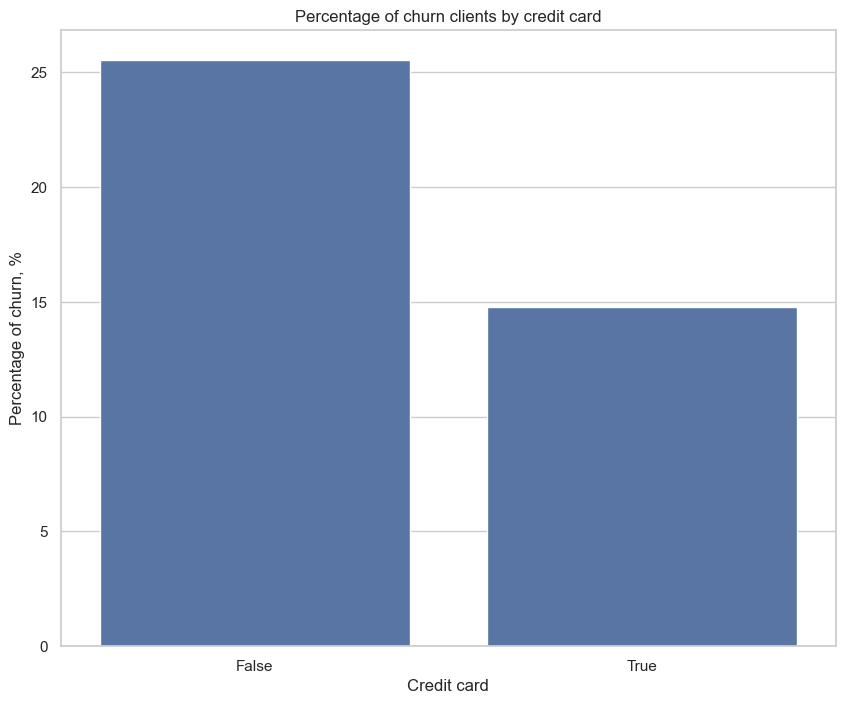

In [31]:
# build a bar chart with shares from churn clients in the context of credit cards
plt.figure(figsize=(10,8))
sns.barplot(x='credit_card', y='churn_share', data=credit_card_churn)
plt.title('Percentage of churn clients by credit card')
plt.xlabel('Credit card')
plt.ylabel('Percentage of churn, %')
plt.show()

Clients who do not have a credit card are 11% more likely to leave than clients who have a credit card.

Consider the proportion of churn clients among those who have been active in the last 3 months and among those who have not

In [32]:
# make a pivot table with shares from churn clients in the context of activity in the last 3 months
last_activity_churn = data.pivot_table(index='last_activity', values='churn', aggfunc=['sum', 'count'])
last_activity_churn = pd.DataFrame(last_activity_churn.reset_index()) 
last_activity_churn.columns = ['last_activity', 'sum_churn', 'sum_total'] # assign the names of the columns in the table
last_activity_churn['churn_share'] = last_activity_churn['sum_churn']/last_activity_churn['sum_total']*100 # creating a new column with a share from the churn clients
last_activity_churn['churn_share'] = last_activity_churn['churn_share'].round(2) # rounding the percentage to 2 decimal places
last_activity_churn

,last_activity,sum_churn,sum_total,churn_share
0,False,541,4758,11.37
1,True,1277,5215,24.49


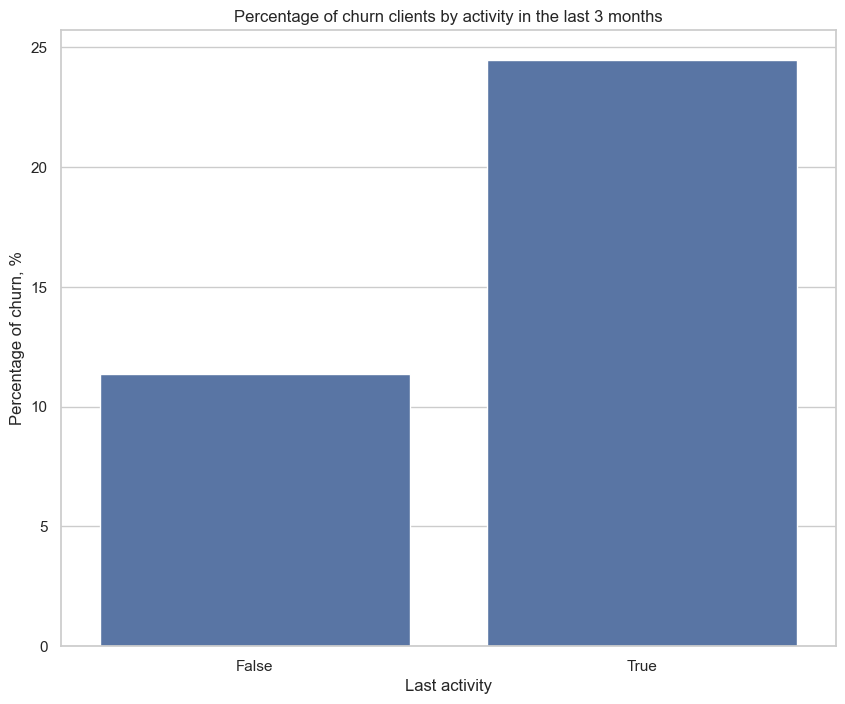

In [33]:
# build a bar chart with shares from churn clients in the context of activity in the last 3 months
plt.figure(figsize=(10,8))
sns.barplot(x='last_activity', y='churn_share', data=last_activity_churn)
plt.title('Percentage of churn clients by activity in the last 3 months')
plt.xlabel('Last activity')
plt.ylabel('Percentage of churn, %')
plt.show()

For the streaming clientss of those who have been active in the last 3 months, there is 13% more than the proportion of the churn clients who were not active.

**For numerical parameters, `equity` and `products` are also used to calculate the share of exact customers in the context of these parameters**

Consider the share of the churn clients in terms of the number of equity

In [34]:
# make a pivot table with shares from churn customers in the context of equity
equity_churn = data.pivot_table(index='equity', values='churn', aggfunc=['sum', 'count'])
equity_churn = pd.DataFrame(equity_churn.reset_index()) 
equity_churn.columns = ['equity', 'sum_churn', 'sum_total'] # assign the names of the columns in the table
equity_churn['churn_share'] = equity_churn['sum_churn']/equity_churn['sum_total']*100 # creating a new column with a share from the churn customers
equity_churn['churn_share'] = equity_churn['churn_share'].round(2) # rounding the percentage to 2 decimal places
equity_churn

,equity,sum_churn,sum_total,churn_share
0,0,90,2576,3.49
1,1,93,773,12.03
2,2,166,1051,15.79
3,3,321,1540,20.84
4,4,464,1847,25.12
5,5,576,1915,30.08
6,6,58,161,36.02
7,7,37,80,46.25
8,8,6,17,35.29
9,9,7,13,53.85


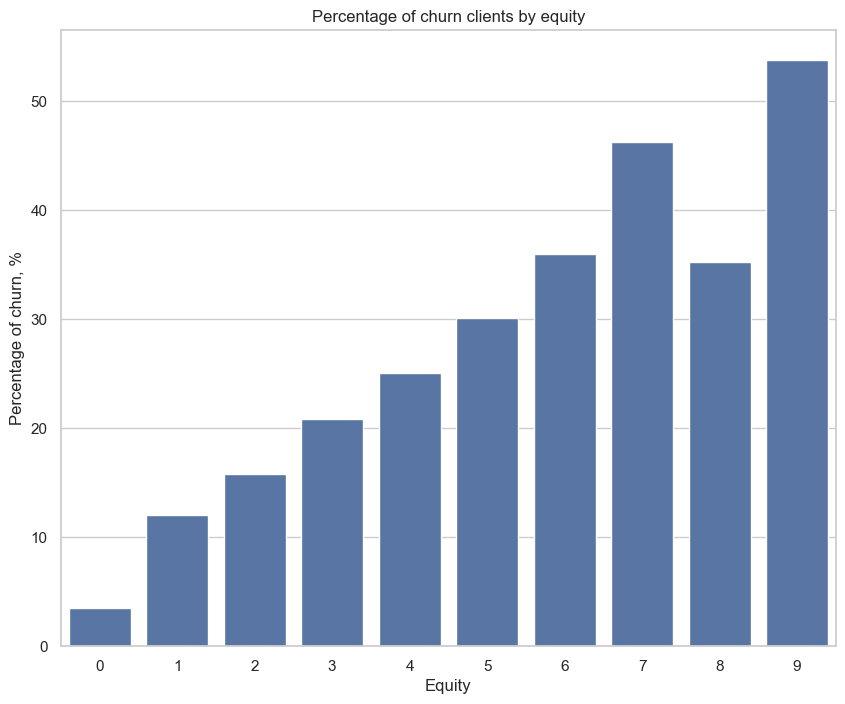

In [35]:
# build a bar chart with shares from churn clients in the context of equity
plt.figure(figsize=(10,8))
sns.barplot(x='equity', y='churn_share', data=equity_churn)
plt.title('Percentage of churn clients by equity')
plt.xlabel('Equity')
plt.ylabel('Percentage of churn, %')
plt.show()

The higher the property score, the higher the percentage of high-quality customers (with the exception of clients with a score of 8, such clients are less high-quality than with a score of 7). It is important to note that more than half of the clients with a property score of 9 leave the bank

Consider the proportion of exact customers in terms of the number of products

In [36]:
# make a pivot table with the shares from the churn clients in terms of the number of products
products_churn = data.pivot_table(index='products', values='churn', aggfunc=['sum', 'count'])
products_churn = pd.DataFrame(products_churn.reset_index()) 
products_churn.columns = ['products', 'sum_churn', 'sum_total'] # assign the names of the columns in the table
products_churn['churn_share'] = products_churn['sum_churn']/products_churn['sum_total']*100 # creating a new column with a share from the churn customers
products_churn['churn_share'] = products_churn['churn_share'].round(2) # rounding the percentage to 2 decimal places
products_churn

,products,sum_churn,sum_total,churn_share
0,1,235,3323,7.07
1,2,978,5119,19.11
2,3,297,1038,28.61
3,4,300,474,63.29
4,5,8,19,42.11


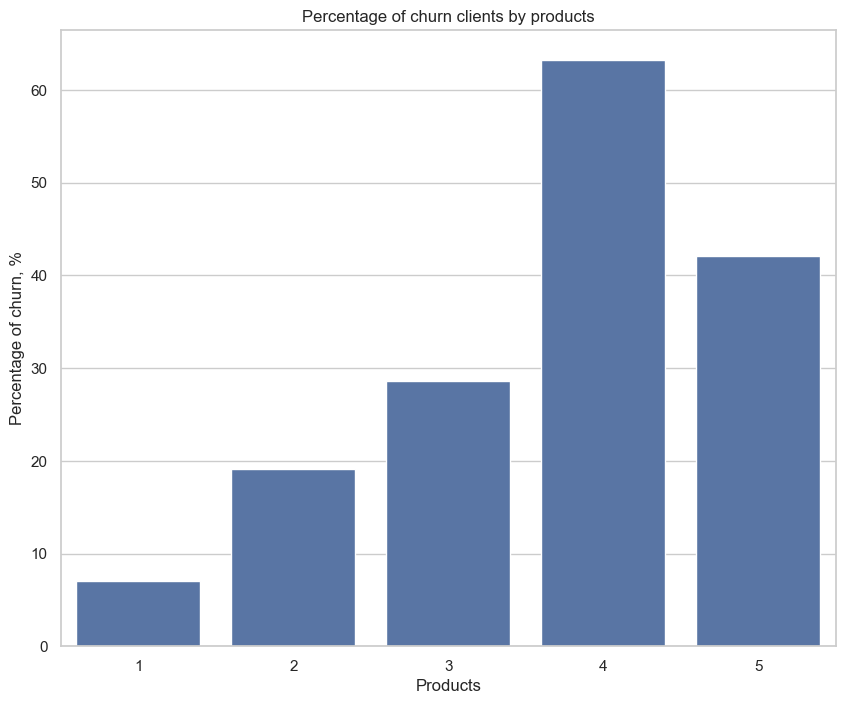

In [37]:
# build a bar chart with the shares of the churn clients in terms of the number of products
plt.figure(figsize=(10,8))
sns.barplot(x='products', y='churn_share', data=products_churn)
plt.title('Percentage of churn clients by products')
plt.xlabel('Products')
plt.ylabel('Percentage of churn, %')
plt.show()

The greater the number of products, the greater the percentage of churn clients (with the exception of clients with 5 products, such clients are less churn than with the number of products equal to 4). It is also important to note that more than half of the clients with the number of products equal to 4 leave the bank (63%)

**Study the distribution of continuous numerical parameters in the context of churn**

For continuous parameters, we will construct histograms of the distribution.

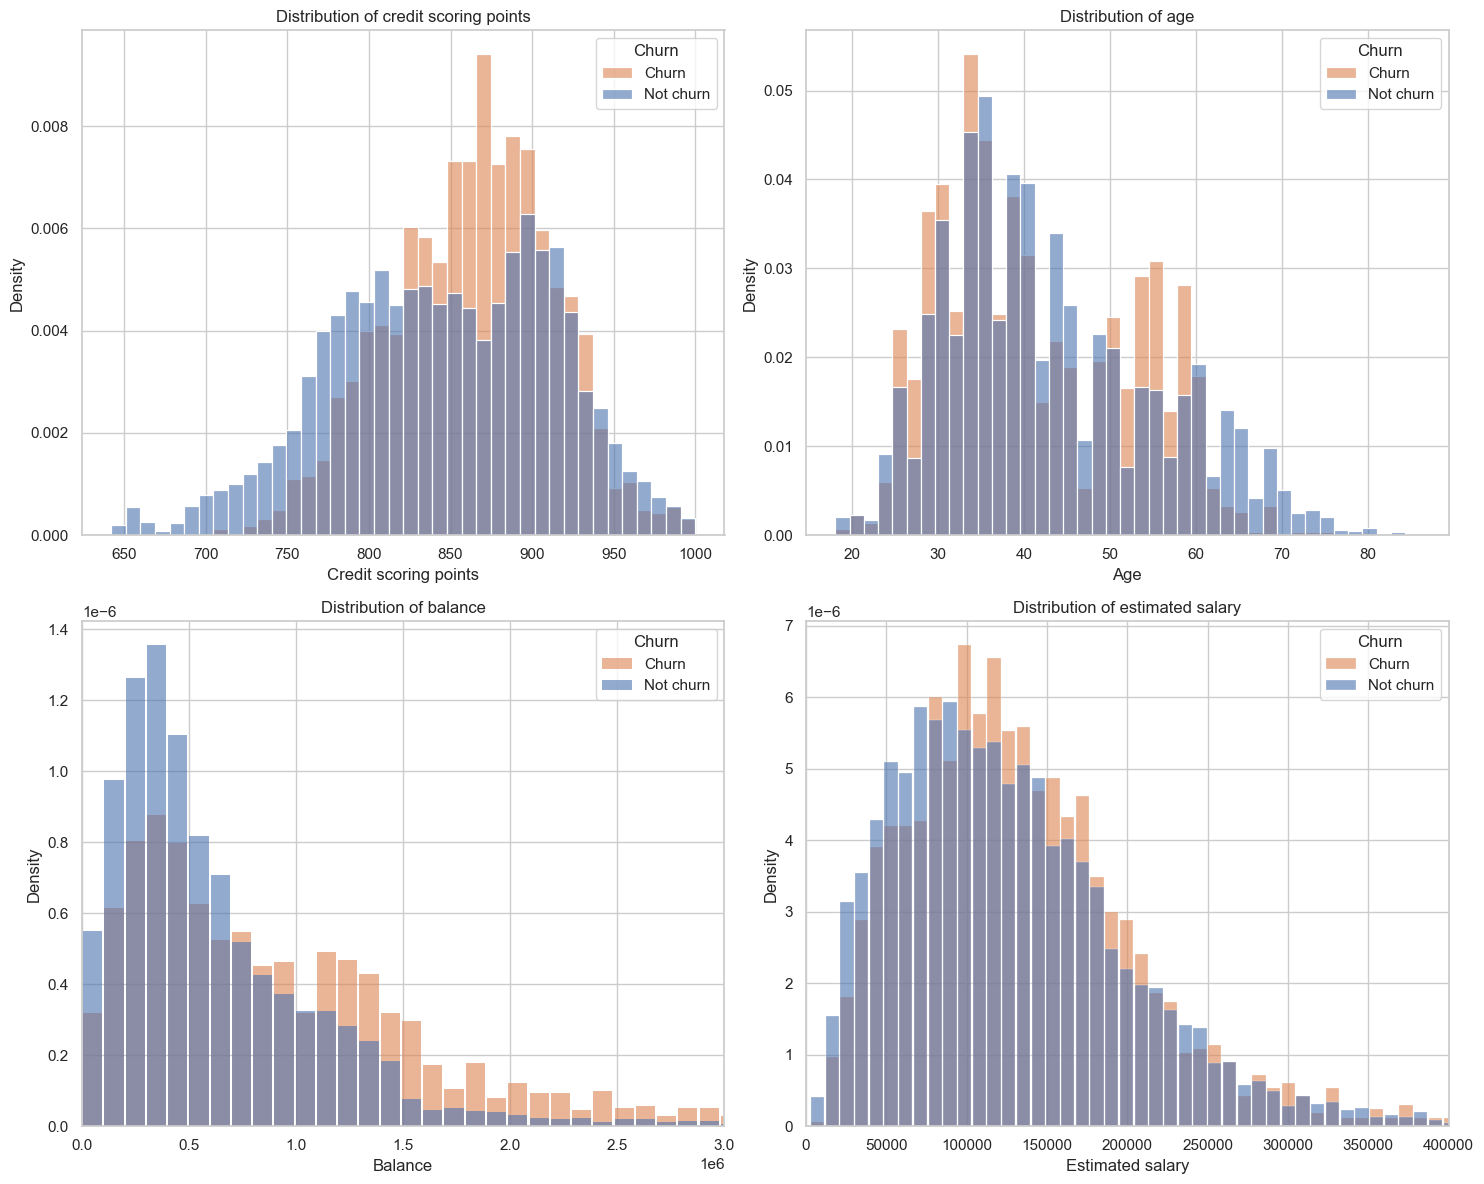

In [38]:
# set the style for the graphs
sns.set(style="whitegrid")

# set the size of the graphs
plt.figure(figsize=(15, 12))

# build histograms for each feature
# score
plt.subplot(2, 2, 1)
sns.histplot(data=data, x="score", hue="churn", kde=False, stat="density", common_norm=False, alpha=0.6)
plt.title("Distribution of credit scoring points")
plt.xlabel("Credit scoring points")
plt.legend(['Churn', 'Not churn'], title='Churn')

# age
plt.subplot(2, 2, 2)
sns.histplot(data=data, x="age", hue="churn", kde=False, stat="density", common_norm=False, alpha=0.6)
plt.title("Distribution of age")
plt.xlabel("Age")
plt.legend(['Churn', 'Not churn'], title='Churn')

# balance
plt.subplot(2, 2, 3)
sns.histplot(data=data, x="balance", hue="churn", kde=False, stat="density", common_norm=False, alpha=0.6, bins=1200, shrink=0.9)
plt.xlim(0, 3000000)
plt.title("Distribution of balance")
plt.xlabel("Balance")
plt.legend(['Churn', 'Not churn'], title='Churn')

# estimated salary
plt.subplot(2, 2, 4)
sns.histplot(data=data, x="est_salary", hue="churn", kde=False, stat="density", common_norm=False, alpha=0.6, shrink=0.9)
plt.xlim(0, 400000)
plt.title("Distribution of estimated salary")
plt.xlabel("Estimated salary")
plt.legend(['Churn', 'Not churn'], title='Churn')

# show all graphs
plt.tight_layout()
plt.show()

For balance and income, we'll plot graphs with ranges of higher values to make sure we haven't missed anything.

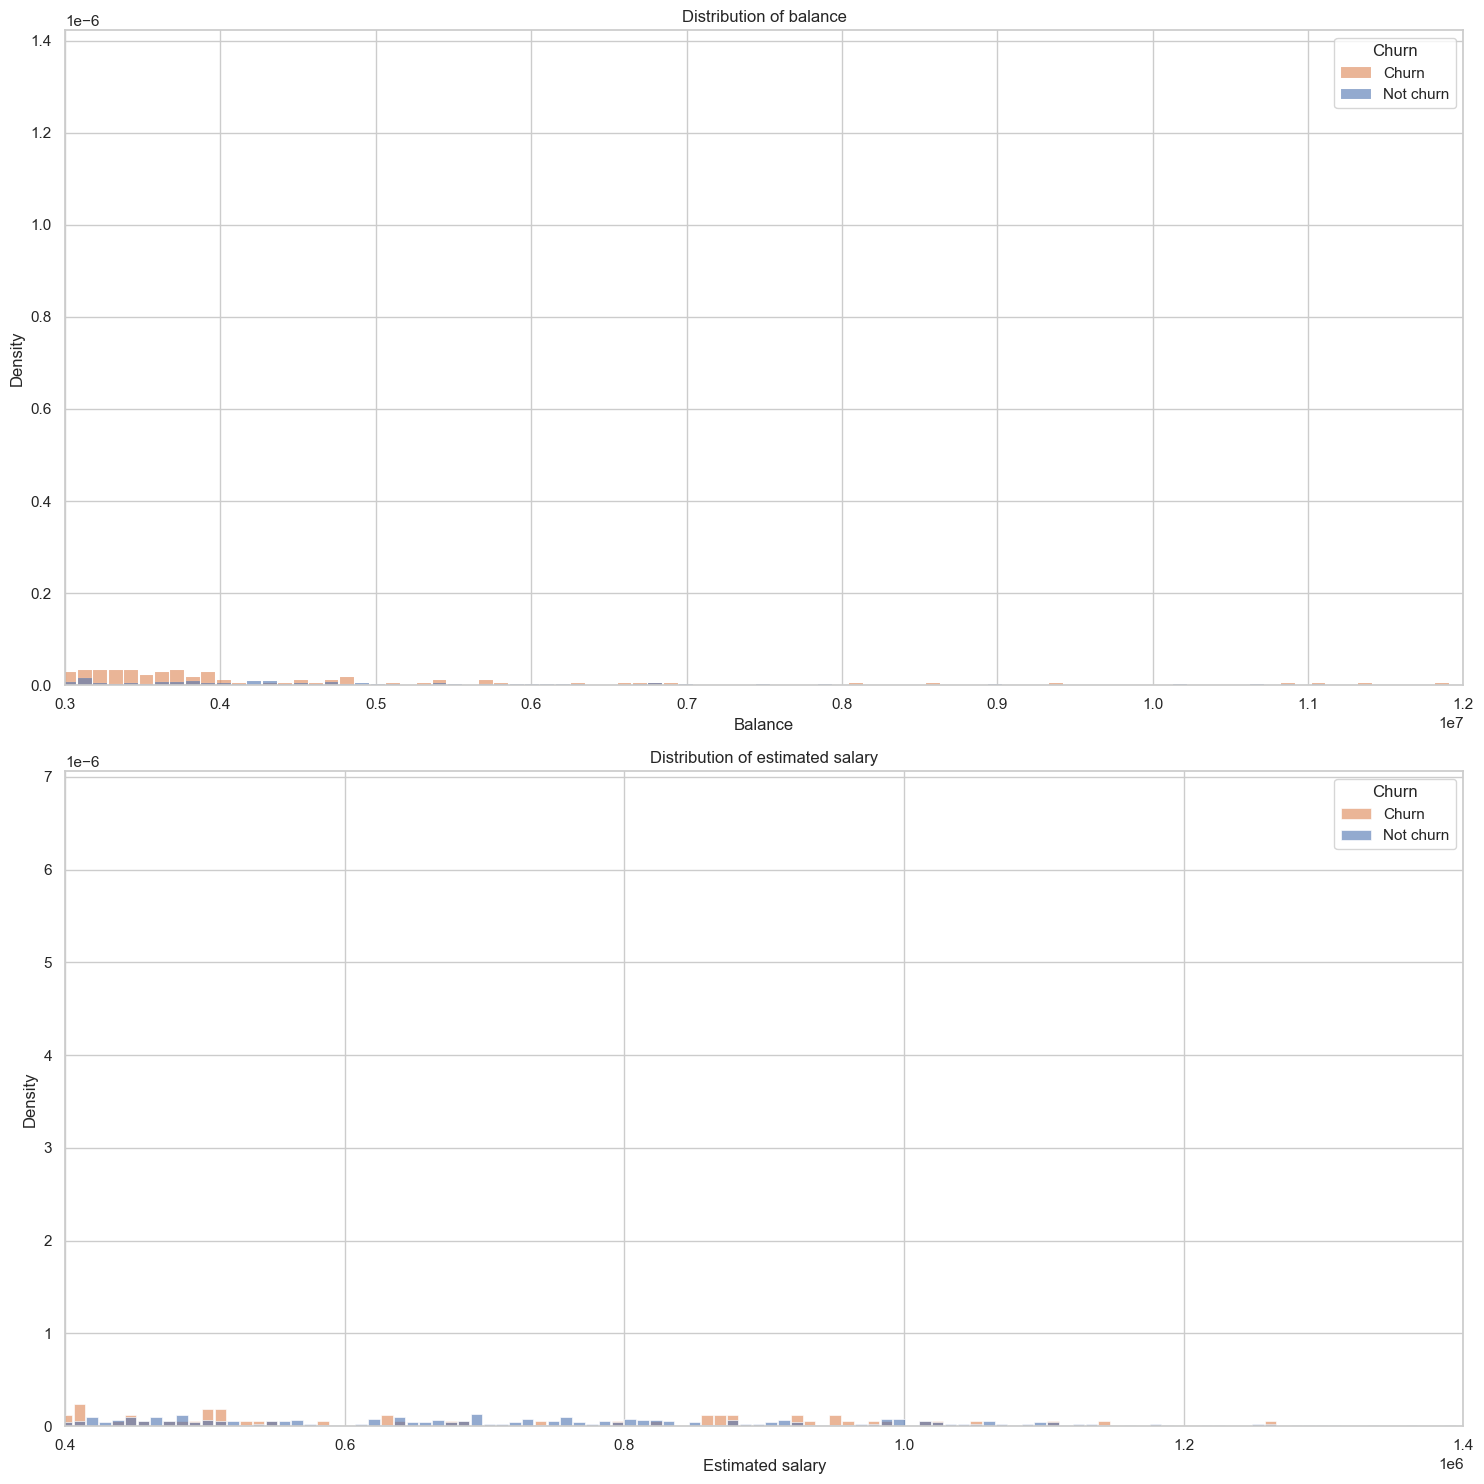

In [39]:
# set the style for the graphs
sns.set(style="whitegrid")

# set the size of the graphs
plt.figure(figsize=(15, 15))

# build histograms for each feature
# balance
plt.subplot(2, 1, 1)
sns.histplot(data=data, x="balance", hue="churn", kde=False, stat="density", common_norm=False, alpha=0.6, bins=1200, shrink=0.9)
plt.xlim(3000000, 12000000)
plt.title("Distribution of balance")
plt.xlabel("Balance")
plt.legend(['Churn', 'Not churn'], title='Churn')

# estimated salary
plt.subplot(2, 1, 2)
sns.histplot(data=data, x="est_salary", hue="churn", kde=False, stat="density", common_norm=False, alpha=0.6, shrink=0.9)
plt.xlim(400000, 1400000)
plt.title("Distribution of estimated salary")
plt.xlabel("Estimated salary")
plt.legend(['Churn', 'Not churn'], title='Churn')

# show all graphs
plt.tight_layout()
plt.show()

In these ranges, the proportion of excess churn or not churn clients varies. The total share is so small that it makes no sense to take this data into account for conclusion on high-churn clients

Based on the constructed diagrams, we see the following:
- when distributing credit scoring points, it is clear that the proportion of churn customers exceeds the proportion of not churn ones in the credit scoring range from about 825 to 925 points  
- clients aged 25 to 35 years and aged 50 to 60 years are more churn. Clients of other ages are more likely to be not churn than churn  
- when distributing the balance on the account, it can be seen that the share of churn customers exceeds the share of not churn ones starting from the balance of 700 thousand rubles and above  
- the distribution of estimated customer income in the context of churn is ambiguous, but the graph clearly shows that customers with an estimated income of up to 90 thousand rubles have a share of churn customers less than the share of not churn ones. Starting with an income of 90 thousand rubles mainly the share of churn clients exceeds the not churn ones, but there are also income ranges where this is not confirmed.

### Comparison of quantitative clients portraits

Compare the appropriate average values of quantitative characteristics between churn and not churn clients, and look at the percentage difference between these groups

In [40]:
# divide the data into two groups: churn and not churn clients
churned_data = data.query('churn == True')
not_churned_data = data.query('churn == False')

# create a list of quantitative characteristics for analysis
quantitative_columns = ['score', 'age', 'equity', 'balance', 'products', 'est_salary']

# calculate the median values for each group
median_churned = churned_data[quantitative_columns].median()
median_not_churned = not_churned_data[quantitative_columns].median()

# calculate the percentage difference between the groups
percentage_diff = (median_churned - median_not_churned) / median_not_churned * 100

# show results
print("Median values for churn clients:")
print(median_churned)
print("\nMedian values for not churn clients:")
print(median_not_churned)
print("\nPercentage difference between churn and not churn clients (in %):")
print(percentage_diff)

Median values for churn clients:
score            866.00
age               39.00
equity             4.00
balance       783908.90
products           2.00
est_salary    125408.88
dtype: float64

Median values for not churn clients:
score            848.00
age               40.00
equity             3.00
balance       475410.09
products           2.00
est_salary    118227.60
dtype: float64

Percentage difference between churn and not churn clients (in %):
score          2.122642
age           -2.500000
equity        33.333333
balance       64.891094
products       0.000000
est_salary     6.074115
dtype: float64


The biggest difference in the median values of the two groups according to the `balance` parameter is almost 65% more than the median account balance for churn clients than for not churn ones. The median number of products is the same for the two groups.  
For churn clients, almost all indicators are higher, except for the age and number of products.

### Analysis of the correlation of signs with the churn sign

Calculate the correlation matrix

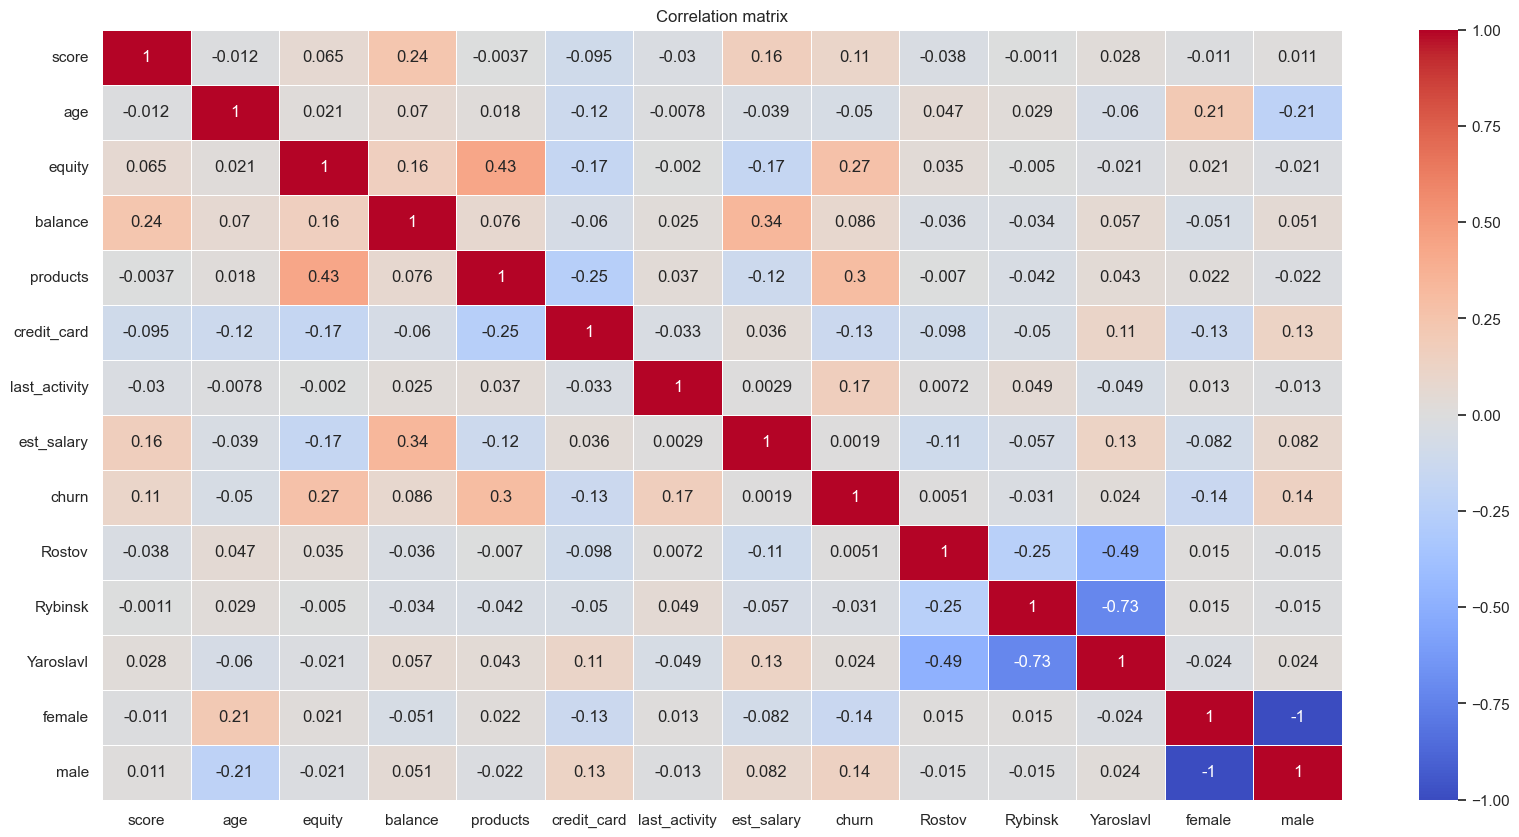

In [41]:
# prepare a table for calculating correlations
data_corr = data.drop(columns = ['user_id', 'city', 'gender'], axis=1)

# calculation of the correlation matrix
corr_matrix = data_corr.corr()

# visualization of the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation matrix")
plt.show()

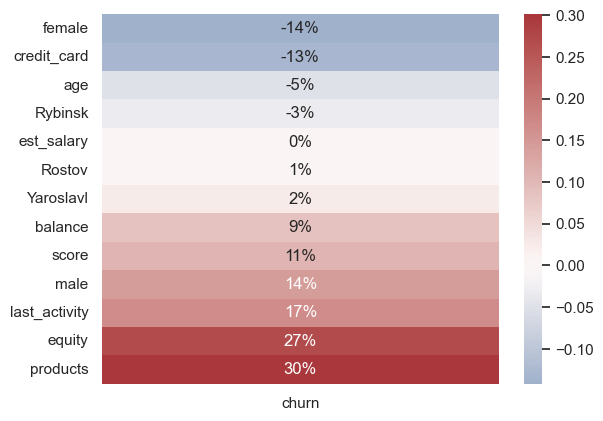

In [42]:
# build a churn correlation diagram of all the features separately
sns.heatmap(corr_matrix.loc[:,['churn']].drop('churn').sort_values('churn'), 
            annot=True, fmt=".0%", cmap="vlag", center=0);

Interpretation of correlations on the Cheddock scale:
- 0.1–0.3: weak correlation  
- 0.3–0.5: moderate correlation  
- 0.5–0.7: noticeable correlation  
- 0.7–0.9: high correlation  
- 0.9–1.0: very high correlation

According to the Cheddock scale, there is no strong relationship between the signs.  
The churn correlates most with the number of products, but the correlation is only 30%, so it cannot be argued that the number of products affects the churn of clients.

**As part of EDA, the following was revealed:**  

- In all cities, the share of churn clients is less than 20%. Least of all in Rybinsk - 16.26%  
- The proportion of churn men is more than the proportion of churn women by 11%  
- Clients who do not have a credit card are 11% more likely to leave than clients who have a credit card  
- The share of churn clients from those who have been active in the last 3 months is 13% more than the share of churn clients who have not been active  
- The higher the equity, the higher the percentage of churn clients (with the exception of clients with a score of 8, such clients are less churn than with a score of 7)  
- The greater the number of products, the greater the percentage of churn clients (with the exception of clients with 5 products, such culients are less churn than with the number of products equal to 4)  
- The share of churn clients exceeds the share of not churn ones in the credit scoring range from about 825 to 925 points  
- Clients aged 25 to 35 years and aged 50 to 60 years are more churn  
- The share of churn clients exceeds the share of not churn ones starting from the balance of 700 thousand rubles and above  
- For clients with estimated income up to 90 thousand rubles, the share of churn clients is less than the share of not churn ones. Starting with an income of 90 thousand rubles basically, the share of churn clients exceeds the share of not churn ones  
- The churn correlates most with the number of products, but the correlation is only 30%, so it cannot be argued that the number of products affects the churn of clients

## Statistical data analysis

### Hypothesis № 1

Test the hypothesis of income differences between those clients who left and those who stayed

Formulate the null and alternative hypotheses:  
**H0:** the average income of the churn and not churn clients is equal  
**H1:** the average income of the churn and not churn clients are not equal

To test the hypothesis, we will conduct a t-test and a u_test  
The Student's t-test assumes that the data in each group are distributed normally and tests the hypothesis of equality of the average of the two samples. It works well on data when the distribution is close to normal and the group variances are similar.  
The Mann-Whitney U-test (or Mann-Whitney test) is a nonparametric test that is used if the data distribution is not normal. It tests the hypothesis of equality of distributions of two samples, not based on the assumption of normality of the data.

In [43]:
# divide the data into groups from the churn and not churn customers
churn_clients = data[data['churn'] == True]['est_salary']
non_churn_clients = data[data['churn'] == False]['est_salary']

# conducting a t-test
t_test_results = st.ttest_ind(churn_clients, non_churn_clients, equal_var=False)

# show results
alpha = 0.05
print(t_test_results.pvalue) 

if t_test_results.pvalue < alpha:
    print('Rejecting the null hypothesis (t-test)')
else:
    print('Failed to reject the null hypothesis (t-test)')

0.8354803526840116
Failed to reject the null hypothesis (t-test)


In [44]:
# carrying out the Mann-Whitney U-test
u_test_results = st.mannwhitneyu(churn_clients, non_churn_clients, alternative='two-sided')
print(u_test_results.pvalue)

if u_test_results.pvalue < alpha:
    print('Rejecting the null hypothesis (u-test)')
else:
    print('Failed to reject the null hypothesis (u-test)')

0.00016830729188229058
Rejecting the null hypothesis (u-test)


The test results are different  
Perhaps the data is not distributed normally or there are outliers that affect the result of the t-test.  
Let's check the data for normality with the Kolmogorov-Smirnov criterion

In [45]:
# calculate the mean and standard deviation
mean_ks = data['est_salary'].mean()
std_ks = data['est_salary'].std()

# apply the Kolmogorov-Smirnov criterion
stat, p_value = st.kstest(data['est_salary'], 'norm', args=(mean_ks, std_ks))

# show results
print(p_value)

if p_value < alpha:
    print("The distribution deviates from the normal")
else:
    print("The distribution does not deviate from the normal")


2.8369664185440544e-294
The distribution deviates from the normal


It follows that we need to trust the result of the Mann-Whitney test (u-test). Therefore, we reject the null hypothesis that the average incomes of the remaining and from the exact clients are equal

### Hypothesis № 2

Test the hypothesis about the influence of age on the tendency of customers to churn

Formulate the null and alternative hypotheses:  
**H0:** the age of the churn and not churn clients is equal  
**H1:** the age of the churn and not churn clients is not equal

To test the hypothesis, we will conduct a t-test:

In [46]:
# divide the data into groups from the churn and not churn customers
churn_clients_age = data[data['churn'] == True]['age']
non_churn_clients_age = data[data['churn'] == False]['age']

# conducting a t-test
results = st.ttest_ind(churn_clients_age, non_churn_clients_age, equal_var=False)
    
# show results
alpha = 0.05
print (results.pvalue) 

if results.pvalue < alpha:
    print ('Rejecting the null hypothesis')
else:
    print ('Failed to reject the null hypothesis')

7.536127357312234e-08
Rejecting the null hypothesis


The conducted t-test showed that it is necessary to reject the null hypothesis that the age of the churn and not churn clients is equal. This means that clients of the same age can be more churn than not churn and vice versa. Therefore, it makes sense to single out clients in segments by age, where there is a high churn

## Client segmentation

Based on the results of the analysis, we will identify several high-churn clients segments.

### Segment № 1

Balance: more than 1 million rubles  
Age: from 25 to 35 years old

In [47]:
# calculate the total number of users in this segment
seg_1_total = data.query(
    'balance > 1000000 and age >=25 and age <= 35')['user_id'].count()

# calculate the number of churn users in this segment
seg_1_churn = data.query (
    'balance > 1000000 and age >=25 and age <= 35 and churn==1')['user_id'].count()

# calculate the share of the churn users in the segment
seg_1_share = seg_1_churn / seg_1_total * 100

print ('Total number of users in segment №1:', seg_1_total)
print ('Number of churn users in segment №1:', seg_1_churn)
print ('Share of the churn users in segment №1:', seg_1_share)

Total number of users in segment №1: 386
Number of churn users in segment №1: 212
Share of the churn users in segment №1: 54.92227979274611


### Segment № 2

Availability of a credit card: yes  
Number of products: 4 or more

In [48]:
# calculate the total number of users in this segment
seg_2_total = data.query(
    'credit_card == True and products >= 4 ')['user_id'].count()

# calculate the number of churn users in this segment
seg_2_churn = data.query (
    'credit_card == True and products >= 4 and churn==1')['user_id'].count()

# calculate the share of the churn users in the segment
seg_2_share = seg_2_churn / seg_2_total * 100

print ('Total number of users in segment №2:', seg_2_total)
print ('Number of churn users in segment №2:', seg_2_churn)
print ('Share of the churn users in segment №2:', seg_2_share)

Total number of users in segment №2: 342
Number of churn users in segment №2: 244
Share of the churn users in segment №2: 71.34502923976608


### Segment № 3

Gender: male  
Number of equity: greater than or equal to 5  
Activity in the last 3 months: yes

In [49]:
# calculate the total number of users in this segment
seg_3_total = data.query(
    'male == 1 and equity >= 5 and last_activity==True')['user_id'].count()

# calculate the number of churn users in this segment
seg_3_churn = data.query (
    'male == 1 and equity >= 5 and last_activity==True and churn==1')['user_id'].count()

# calculate the share of the churn users in the segment
seg_3_share = seg_3_churn / seg_3_total * 100

print ('Total number of users in segment №3:', seg_3_total)
print ('Number of churn users in segment №3:', seg_3_churn)
print ('Share of the churn users in segment №3:', seg_3_share)

Total number of users in segment №3: 595
Number of churn users in segment №3: 324
Share of the churn users in segment №3: 54.45378151260504


**Conclusion**  
We have identified 3 high-churn segments that need to be worked with

## Conclusions and recommendations

### Conclusions  

We conducted an analysis of the churn of clients in Metanprombank.  

**Data preprocessing was performed**, during which the data was made in form ready for analysis.  

**A exploratory analysis of the data was performed.**  
As part of the EDA, the general portraits of the bank's clients, as well as clients in the context of churn, were considered.  
- In all cities, the share of churn clients is less than 20%. Least of all in Rybinsk - 16.26%  
- The proportion of churn men is more than the proportion of churn women by 11%  
- Clients who do not have a credit card are 11% more likely to leave than clients who have a credit card  
- The share of churn clients from those who have been active in the last 3 months is 13% more than the share of churn clients who have not been active  
- The higher the equity score, the higher the percentage of churn clients (with the exception of clients with a score of 8, such clients are less churn than with a score of 7)  
- The greater the number of products, the greater the percentage of churn clients (with the exception of clients with 5 products, such clients are less churn than with the number of products equal to 4)  
- The share of churn clients exceeds the share of not churn clients in the credit scoring range from about 825 to 925 points  
- Clients aged 25 to 35 years and aged 50 to 60 years are more churn  
- The share of churn clients exceeds the share of not churn clients starting from the balance of 700 thousand rubles and above  
- For clients with estimated income up to 90 thousand rubles, the share of churn clients is less than the share of not churn ones. Starting with an income of 90 thousand rubles basically, the share of churn clients exceeds the share of not churn ones  
- The churn correlates most with the number of products, but the correlation is only 30%, so it cannot be argued that the number of products affects the churn of clients

**As part of the statistical analysis, 2 hypotheses were tested:**  
The conducted t-tests showed that it is impossible to reject the null hypothesis that there are no differences in the income of the churn and not churn clients, and it is also necessary to reject the null hypothesis that the age of the churn and not churn clients is equal.  

**Based on the results of the analysis, 3 high-churn client segments were identified.**  

**Segment No. 1**  
- Balance: more than 1 million rubles.  
- Age: from 25 to 35 years old  

**Segment No. 2**  
- Availability of a credit card: yes  
- Number of products: 4 or more  

**Segment No. 3**  
- Gender: male  
- Number of equity: greater than or equal to 5  
- Activity in the last 3 months: yes

### Recommendations  


**Recommendations for segment № 1**  
Clients with a large balance (more than 1 million rubles) at a young age are often interested in effective management of their funds and increasing their capital. The Bank can offer:
   - Special investment offers: access to profitable investment products (for example, with higher interest rates or exclusive investment funds).  
   - Premium cards with special privileges, such as cashback, insurance and exclusive offers.
   - Special service conditions, for example, faster transactions, premium service in the bank's offices without queues, dedicated managers to work with clients


**Recommendations for segment № 2**  
To reduce churn among clients with a credit card and 4 or more bank products, it is important to focus on retaining these clients through comprehensive loyalty programs, improving product conditions and simplifying interaction with the bank. 
   - Advanced cashback programs for credit card holders. For example, an increase in cashback for regular purchases or categorical bonuses (fuel, groceries, travel).
   - Package offers with special conditions for owners of several products. For example, if a customer uses four or more products, they may receive premium offers for other services (free credit card service, reduced interest on loans or mortgages).
   - Reduced service fees for active use of more than four products.
   - A program for accumulating bonus points with the possibility of exchanging for discounts, improved loan conditions or exclusive offers 

**Recommendations for segment № 3**  
Clients with high score of equiity often need special products that are aimed at managing their assets. The Bank can offer:
- Personal investment and capital management offers. Clients with a high level of ownership may be interested in profitable investment products such as high-interest rate deposits, bonds and individual investment accounts.
- Package offers for owners. For example, property insurance with exclusive conditions, tax advice and legal support for clients with high-level property.  
- Since customers have been active in the last three months, the bank can offer personalized offers based on previous transactions — for example, if the customer actively uses card products, offer an increased limit or new favorable loan terms